# dask.delayed - parallelize any code

- decorate function @delayed

In [2]:
from dask.distributed import Client
client = Client(n_workers=4)

/opt/homebrew/Caskroom/miniforge/base/envs/dask_1/lib/python3.9/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 50693 instead
  warnings.warn(


In [3]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:50693/status,
Dashboard: http://127.0.0.1:50693/status,Workers: 4
Total threads: 12,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50694,Workers: 4
Dashboard: http://127.0.0.1:50693/status,Total threads: 12
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:50710,Total threads: 3
Dashboard: http://127.0.0.1:50713/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:50699,


# for-loop에서 사용해보기

In [ ]:
import dask

@dask.delayed
def process_file(filename):
    data = read_a_file(filename)
    data = do_a_transformation(data)
    destination = f"results/{filename}"
    write_out_data(data, destination)
    return destination

results = []
for filename in filenames:
    results.append(process_file(filename))

dask.compute(results)

# Basics

# origin version

In [9]:
from time import sleep
def inc(x):
    sleep(1)
    return x + 1


def add(x, y):
    sleep(1)
    return x + y

In [10]:
%%time
# This takes three seconds to run because we call each
# function sequentially, one after the other

x = inc(1)
y = inc(2)
z = add(x, y)

CPU times: user 277 ms, sys: 75.3 ms, total: 353 ms
Wall time: 3.02 s


# Dask Version

In [11]:
import dask

@dask.delayed
def inc(x):
    sleep(1)
    return x + 1


@dask.delayed
def add(x, y):
    sleep(1)
    return x + y

In [12]:
%%time
# notihing complete 
# This runs immediately, all it does is build a graph

x = inc(1)
y = inc(2)
z = add(x, y)

CPU times: user 535 µs, sys: 42 µs, total: 577 µs
Wall time: 585 µs


In [13]:
%%time
# This actually runs our computation using a local thread pool

z.compute()

CPU times: user 218 ms, sys: 61.6 ms, total: 280 ms
Wall time: 2.05 s


5

In [14]:
z # lazy Delayed object

Delayed('add-c0f22089-4372-498f-b8e5-431fce4c8e72')

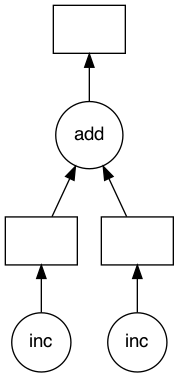

In [15]:
# Look at the task graph for `z`
z.visualize()


#### 왜 코드 속도가 3초에서 2초로 줄어 들었을까 ? 
- 다음 예제로 확인해보자

# Exercise2 : Parallelize a for loop

In [16]:
data = [1, 2, 3, 4, 5, 6, 7, 8]

In [17]:
%%time
# Sequential code

def inc(x):
    sleep(1)
    return x + 1


results = []
for x in data:
    y = inc(x)
    results.append(y)

total = sum(results)

CPU times: user 776 ms, sys: 201 ms, total: 977 ms
Wall time: 8.03 s


In [19]:
%%time

@dask.delayed
def inc(x):
    sleep(1)
    return x + 1

results = []
for x in data:
    y = inc(x)
    results.append(y)

total = sum(results)
print("Before computing:", total)  # Let's see what type of thing total is
result = total.compute()
print("After computing :", result)  # After it's computed

Before computing: Delayed('add-0c5e4312d940210f2bbf465bd746b495')
After computing : 44
CPU times: user 125 ms, sys: 31.3 ms, total: 157 ms
Wall time: 1.07 s


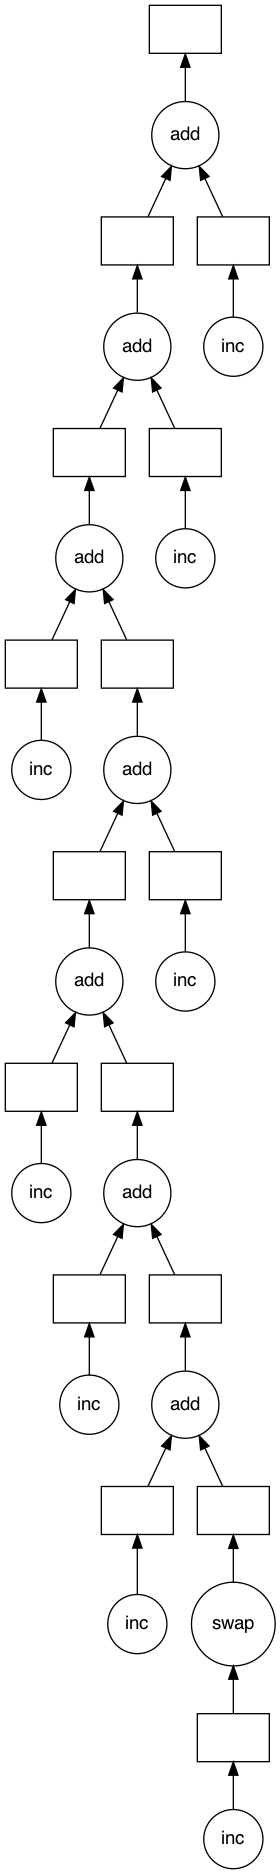

In [20]:
total.visualize()

# pandas groupby Parallelize

In [24]:
%run prep.py -d flights

In [25]:
import os

sorted(os.listdir(os.path.join("data", "nycflights")))

['1990.csv',
 '1991.csv',
 '1992.csv',
 '1993.csv',
 '1994.csv',
 '1995.csv',
 '1996.csv',
 '1997.csv',
 '1998.csv',
 '1999.csv']

In [26]:
import pandas as pd

df = pd.read_csv(os.path.join("data", "nycflights", "1990.csv"))
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990,1,1,1,1621.0,1540,1747.0,1701,US,33,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990,1,2,2,1547.0,1540,1700.0,1701,US,33,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990,1,3,3,1546.0,1540,1710.0,1701,US,33,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990,1,4,4,1542.0,1540,1710.0,1701,US,33,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990,1,5,5,1549.0,1540,1706.0,1701,US,33,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


In [28]:
from glob import glob

filenames = sorted(glob(os.path.join("data", "nycflights", "*.csv")))


In [30]:
%%time
# Sequential code: Mean Departure Delay Per Airport

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = pd.read_csv(fn)
    # Groupby origin airport
    by_origin = df.groupby("Origin")
    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()
    # Number of flights by origin
    count = by_origin.DepDelay.count()
    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

CPU times: user 1.85 s, sys: 394 ms, total: 2.25 s
Wall time: 2.18 s


In [33]:
%%time
# This is just one possible solution, there are
# several ways to do this using `dask.delayed`

@dask.delayed
def read_file(filename):
    # Read in file
    return pd.read_csv(filename)

sums = []
counts = []
for fn in filenames:
    # Delayed read in file
    df = read_file(fn)

    # Groupby origin airport
    by_origin = df.groupby("Origin")

    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()

    # Number of flights by origin
    count = by_origin.DepDelay.count()

    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean, *_ = dask.compute(total_delays / n_flights)

CPU times: user 92.6 ms, sys: 42.3 ms, total: 135 ms
Wall time: 580 ms


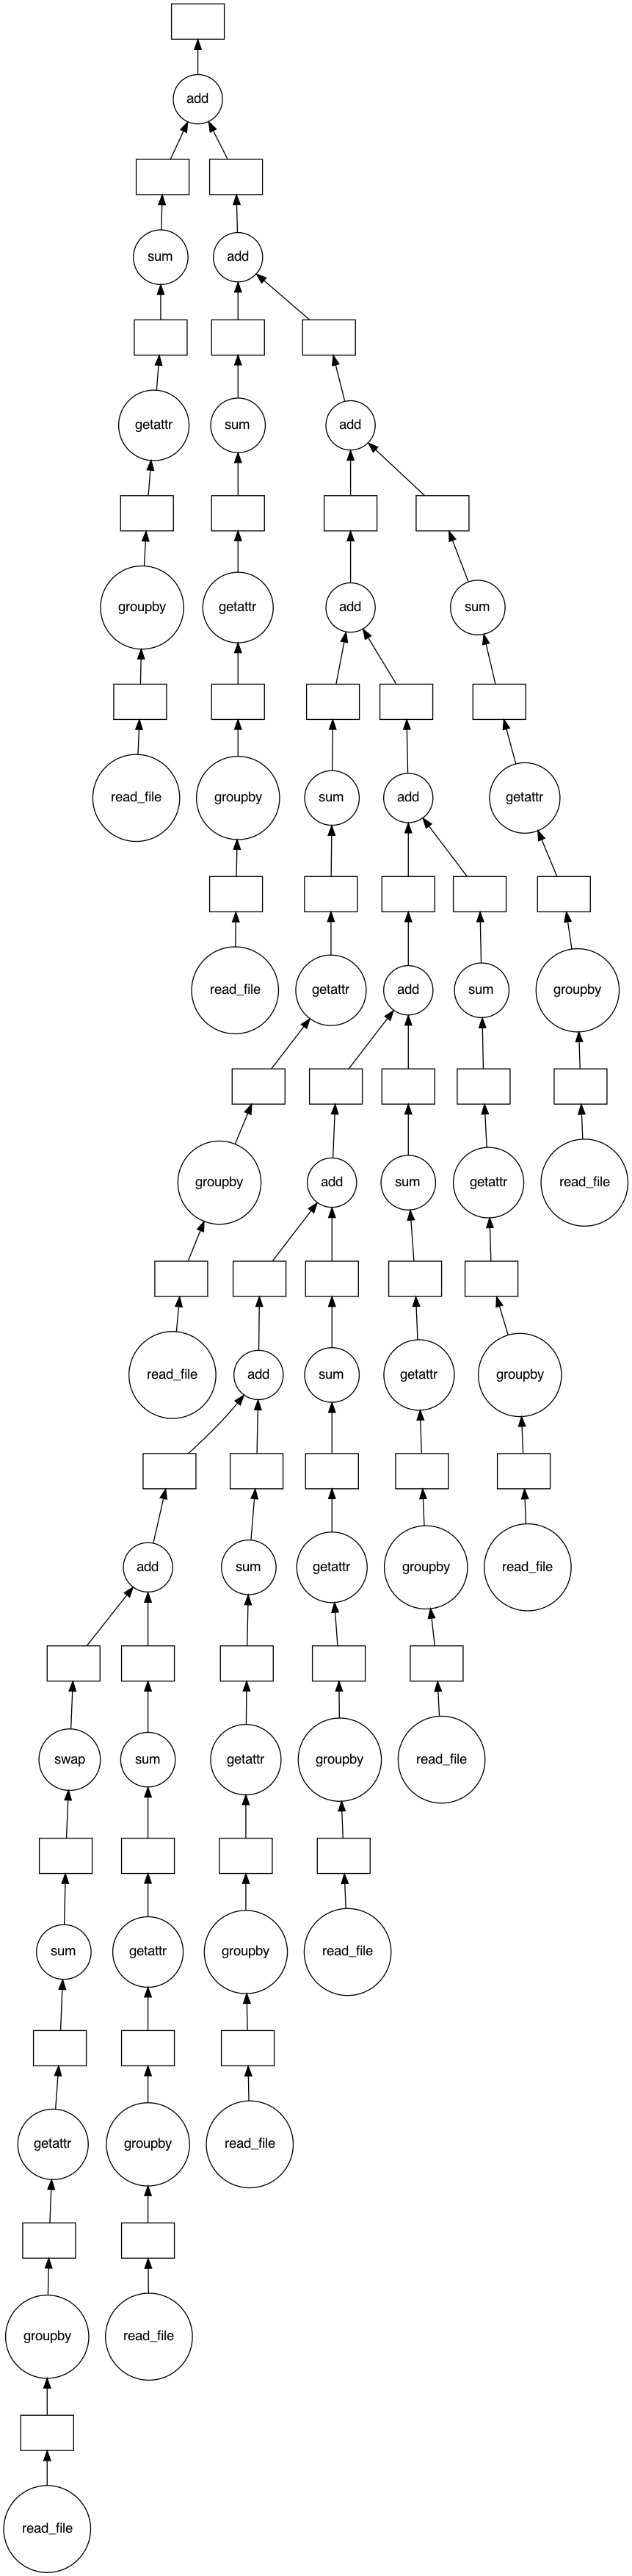

In [34]:
(sum(sums)).visualize()

In [35]:
mean

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

In [36]:
client.close()